# Linear Regressions for house price prediction

In this colab, we will build different linear regression models for california house price prediction.

1. Linear Regression (normal eqn and iterative optimization)
2. Polynomial regression
3. Regularized regression models- ridge and lasso

We will set regularization rate and polynomial degree with hyper parameter tuning and cross validation.

We will compare different models in terms of their parameter vectors and mean absolute error on train, dev and test sets.

In [1]:
#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline


# Common set up

In [2]:
#set random seed
np.random.seed(306)

In [3]:
# Configure shuffle splt
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Data Loading and splitting

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features,labels,random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

# Linear Regression with normal equation

Let's use normal equation method to train linear regression model.

We set up pipeline with two stages:

* Feature scaling to scale features and 
* Linear regression on the tranformed feature matrix.

Throughout this colab, we will have the following pattern for each estimator:

* We will be using Pipeline for combining data preprocessing and modeling steps.
* cross_validate for training the model with ShuffleSplit cross validation and neg-Mean_absolute_error as a scoring metric.
* Convert the scores to error and report mean absolute errors on the dev set.

In [41]:
lin_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                             ('lin_reg',LinearRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring='neg_mean_absolute_error',
                                    return_train_score=True,
                                    return_estimator=True)
lin_reg_train_error = -1 * lin_reg_cv_results['train_score']
lin_reg_test_error = -1 * lin_reg_cv_results['test_score']
print(f'{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}')
print(f'{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}')

0.530 +/- 0.002
0.527 +/- 0.008


In [42]:
lin_reg_cv_results

{'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]

# Linear regression with SGD

Let's use iterative optimization method to train linear regression model.

We use pipeline with two stages:
1. Feature Scaling and
2. SGD regression on the transformed feature matrix

In [7]:
sgd_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                             ('sgd_reg',SGDRegressor(max_iter=np.ceil(1e6/com_train_features.shape[0]),
                                            early_stopping=True,
                                            eta0=1e-4,
                                            learning_rate='constant',
                                            tol=1e-5,
                                            validation_fraction=0.1,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                              com_train_features,
                              com_train_labels,
                              cv=cv,
                              scoring='neg_mean_absolute_error',
                              return_train_score=True,
                              return_estimator=True)

sgd_train_error = -1 * sgd_reg_cv_results['train_score']
sgd_test_error = -1 * sgd_reg_cv_results['test_score']
print(sgd_train_error.mean(),'+/-',lin_reg_train_error.std())
print(sgd_test_error.mean(),'+/-',lin_reg_test_error.std())

0.5640399853222634 +/- 0.002321293528619106
0.5607392935103552 +/- 0.007781288307852414


# Polynomial regression

We will use degree 2 followed by validation curve to find right degree to use for polynomial models.

In [8]:
poly_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg',LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring='neg_mean_absolute_error',
                                    return_train_score=True,
                                    return_estimator=True)
poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']
print(poly_reg_train_error.mean(),'+/-',poly_reg_train_error.std())
print(poly_reg_test_error.mean(),'+/-',poly_reg_test_error.std())

0.4609643523643526 +/- 0.002977081038774082
0.4854459947853935 +/- 0.03031241731076378


Notice the reduction in error

We would now use interaction feature terms only

In [9]:
poly_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                              ('feature_scaling', StandardScaler()),
                              ('lin_reg',LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring='neg_mean_absolute_error',
                                    return_train_score=True,
                                    return_estimator=True)
poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']
print(poly_reg_train_error.mean(),'+/-',poly_reg_train_error.std())
print(poly_reg_test_error.mean(),'+/-',poly_reg_test_error.std())

0.4778194330975899 +/- 0.002820194504598809
0.4968715693459049 +/- 0.02438651181247636


Let's figure out the best degree suited for regression task

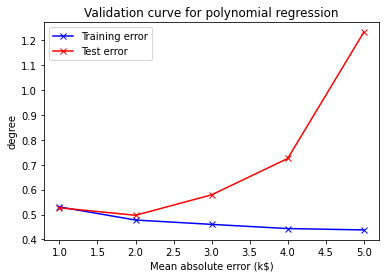

In [10]:
degree = [1,2,3,4,5]

train_scores, test_scores = validation_curve(poly_reg_pipeline, com_train_features, com_train_labels, param_name='poly__degree',
                                             param_range=degree, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis=1),'b-x',label='Training error')
plt.plot(degree, test_errors.mean(axis=1),'r-x',label='Test error')
plt.legend()

plt.ylabel('degree')
plt.xlabel('Mean absolute error (k$)')
_=plt.title('Validation curve for polynomial regression')

#Ridge Regression

The polynomial models have a tendency to overfit- if we use higher order polynomial features. We will use Ridge regression-which penalizes for excessive model complexity in the polynomial regression by adding a regularization term. Here we specify the regularization rate alpha as 0.5 and train the regression model. Later we will launch hyperparameter search for the right value of alpha such that it leads to the least cross validation errors.

In [46]:
ridge_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('ridge',Ridge(alpha=0.5))])
ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring='neg_mean_absolute_error',
                                      return_train_score=True,
                                      return_estimator=True)
ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']
print(ridge_reg_train_error.mean(),'+/-',ridge_reg_train_error.std())
print(ridge_reg_test_error.mean(),'+/-',ridge_reg_test_error.std())

0.48056875234962393 +/- 0.003485200424375767
0.48669297649039295 +/- 0.0056520049058045455


# HPT for ridge regularization rate

In [12]:
alpha_list = np.logspace(-4,0,num=20)
ridge_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('ridge_cv',RidgeCV(alphas=alpha_list,
                                                  cv=cv,
                                                  scoring='neg_mean_absolute_error'))])
ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

In [13]:
print('Score with best alpha', ridge_reg_cv_results[-1].best_score_)
print('Error with best alpha', -ridge_reg_cv_results[-1].best_score_)
print('Best alpha', ridge_reg_cv_results[-1].alpha_)

Score with best alpha -0.4729407010073685
Error with best alpha 0.4729407010073685
Best alpha 0.007847599703514606


## RidgeCV with cross validation

Exercise

## Ridge HPT through GridSearchCV

In [14]:
ridge_grid_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                                ('feature_scaling', StandardScaler()),
                                ('ridge',Ridge())])

param_grid = {'poly__degree':(1,2,3),
              'ridge__alpha':np.logspace(-4,0,num=20)}

ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=-1,
                                 cv=cv,
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True)
ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

ridge_grid_search.best_index_ gives us the index of the best parameter in the list.

In [15]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_['std_test_score'][ridge_grid_search.best_index_]

In [16]:
print('Best mean absolute error of polynomial ridge regression model on the train set:', mean_train_error,' +/- ', std_train_error)
print('Mean absolute error of polynomial ridge regression model on the test set:', mean_test_error,' +/- ', std_test_error)

Best mean absolute error of polynomial ridge regression model on the train set: 0.46267528613770903  +/-  0.003513947906730257
Mean absolute error of polynomial ridge regression model on the test set: 0.4738651176991914  +/-  0.014596293567007597


In [17]:
print('Mean cross validated score', ridge_grid_search.best_score_)
print('Mean cross validated error', -ridge_grid_search.best_score_)
print('Best alpha', ridge_grid_search.best_params_)

Mean cross validated score -0.4738651176991914
Mean cross validated error 0.4738651176991914
Best alpha {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


# Lasso regression

## Baseline model with fixed learning rate

In [18]:
lasso_reg_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('lasso',Lasso(alpha=0.01))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring='neg_mean_absolute_error',
                                      return_train_score=True,
                                      return_estimator=True)
lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']
print(lasso_reg_train_error.mean(),'+/-',lasso_reg_train_error.std())
print(lasso_reg_test_error.mean(),'+/-',lasso_reg_test_error.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

0.5293087458828422 +/- 0.0027964209722316806
0.5279892540601925 +/- 0.007894893222386762


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 1.658e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


# HPT for lasso regularization rate

## with Cross validation

exercise

##with GridSearchCV

In [19]:
lasso_grid_pipeline = Pipeline([('poly', PolynomialFeatures()),
                              ('feature_scaling', StandardScaler()),
                              ('lasso',Lasso())])

param_grid = {'poly__degree':(1,2,3),
              'lasso__alpha': np.logspace(-4,0,num=20)}

lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                 param_grid = param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True)
lasso_grid_search.fit(com_train_features, com_train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+03, tolerance: 2.066e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'poly__degree': (1, 2, 3)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [20]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_['std_test_score'][lasso_grid_search.best_index_]

In [21]:
print('Best mean absolute error of polynomial lasso regression model on the train set:', mean_train_error,' +/- ', std_train_error)
print('Mean absolute error of polynomial lasso regression model on the test set:', mean_test_error,' +/- ', std_test_error)

Best mean absolute error of polynomial lasso regression model on the train set: 0.4621567474002089  +/-  0.0029073058576692384
Mean absolute error of polynomial lasso regression model on the test set: 0.48798304453391356  +/-  0.04575632976840528


In [22]:
print('Mean cross validated score', lasso_grid_search.best_score_)
print('Mean cross validated error', -lasso_grid_search.best_score_)
print('Best alpha', lasso_grid_search.best_params_)

Mean cross validated score -0.48798304453391356
Mean cross validated error 0.48798304453391356
Best alpha {'lasso__alpha': 0.0001, 'poly__degree': 3}


# SGD: Regularization and HPT

In [23]:
poly_sgd_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('feature_scaling', StandardScaler()),
                              ('sgd_reg',SGDRegressor(penalty='elasticnet',
                                                      random_state=42))])
poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      n_jobs=2,
                                      scoring='neg_mean_absolute_error',
                                      return_train_score=True,
                                      return_estimator=True)
poly_sgd_train_error = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_error = -1 * poly_sgd_cv_results['test_score']
print(poly_sgd_train_error.mean(),'+/-',poly_sgd_train_error.std())
print(poly_sgd_test_error.mean(),'+/-',poly_sgd_test_error.std())

10824283052.546406 +/- 4423288211.831954
10946788540.249527 +/- 5396536227.7027445


Let's search for best set of params for ploy+SGD

In [24]:
class uniform_int:
  def __init__(self,a,b):
    self.distribution = uniform(a,b)
  def rvs(self, *args, **kwargs):
    return self._distribution.rvs(*args, **kwargs).astype(int)

Let's specify RandomizedSearchCV setup

In [26]:
param_distributions = {
    'poly__degree':[1,2,3],
    'sgd_reg__learning_rate':['constant','adaptive','invscalig'],
    'sgd_reg__l1_ratio':uniform(0,1),
    'sgd_reg__eta0':loguniform(1e-5,1),
    'sgd_reg__power_t':uniform(0,1)
}

poly_sgd_random_search = RandomizedSearchCV(
    poly_sgd_pipeline, param_distributions=param_distributions,
    n_iter=10,cv=cv,verbose=1,scoring='neg_mean_absolute_error'
)

poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 185, in _get_learning_rate_type
    return LEARNING_RATE_TYPES[learning_rate]
KeyError: 'invscalig'

The above exception was the direct cause of th

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9e6d168810>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9e6bc71450>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'a

The best score can be obtained as follows:

In [27]:
poly_sgd_random_search.best_score_

-0.5271573234998475

The best set of parameters are obtained as follows:

In [28]:
poly_sgd_random_search.best_params_

{'poly__degree': 2,
 'sgd_reg__eta0': 2.3063822138075523e-05,
 'sgd_reg__l1_ratio': 0.4590765695698895,
 'sgd_reg__learning_rate': 'adaptive',
 'sgd_reg__power_t': 0.17208702250773023}

and the best estimator can be accessed with best_estimator_ member variable.

# Comparison of weight vectors

Let's look at the weight vectors produced by different models.

In [29]:
feature_names = poly_reg_cv_results['estimator'][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype=object)

In [32]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results['estimator']]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

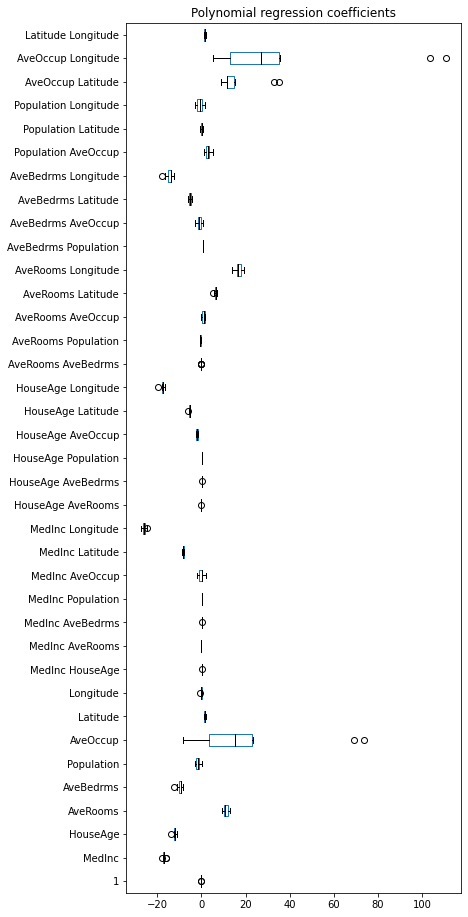

In [33]:
color = {'whiskers':'black','medians':'black','caps':'black'}
weights_polynomial_regression.plot.box(color=color,vert=False,figsize=(6,16))
_=plt.title('Polynomial regression coefficients')

In [49]:
feature_names = ridge_reg_cv_results['estimator'][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [51]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results['estimator']]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

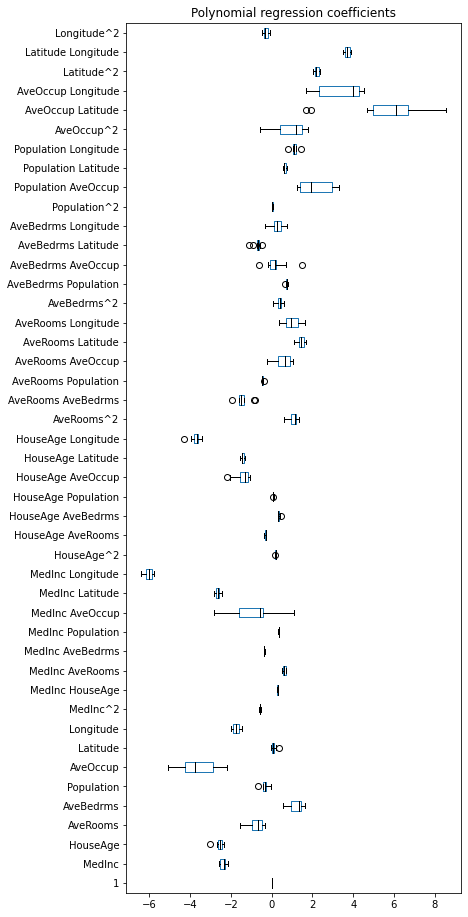

In [52]:
color = {'whiskers':'black','medians':'black','caps':'black'}
weights_ridge_regression.plot.box(color=color,vert=False,figsize=(6,16))
_=plt.title('Polynomial regression coefficients')

# Performance on the test set

## Baseline

In [34]:
baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels,baseline_model_median.predict(test_features))

0.5348927548151625

## Linear regression with normal equation

In [54]:
mean_absolute_percentage_error(test_labels,lin_reg_cv_results['estimator'][0].predict(test_features))

0.32120472175482906

##Polynomial regression

In [55]:
mean_absolute_percentage_error(test_labels,poly_sgd_random_search.best_estimator_.predict(test_features))

0.31523619087395877

##Ridge Regression

In [56]:
mean_absolute_percentage_error(test_labels,ridge_grid_search.best_estimator_.predict(test_features))

0.27110336451421413

##Lasso Regression

In [57]:
mean_absolute_percentage_error(test_labels,lasso_grid_search.best_estimator_.predict(test_features))

0.28074969263810107